### First approach

In [1]:
import os

os.chdir("/home/adamczykb/rnaquanet/src")
os.environ['MLFLOW_TRACKING_USERNAME']='admin'
os.environ['MLFLOW_TRACKING_PASSWORD']='TI5du9by'


In [2]:
import torch
import torch.nn as nn
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDataset
from rnaquanet.dataset.RNAQuANetDataset import RNAQuANetDatasetSubset

from torch_geometric import nn as gnn
import lightning as L
from torch_geometric.loader import DataLoader
from numpy import inf
import torchsort


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def spearman(predictions, targets):

    n = len(predictions.view(-1))

    # Calculate the differences between rankings
    d = torch.argsort(targets.view(-1), dim=-1) - torch.argsort(
        predictions.view(-1), dim=-1
    )

    # Square the differences
    d_squared = d**2

    # Sum the squared differences
    d_squared_sum = torch.sum(d_squared)

    # Calculate Spearman correlation coefficient
    # Formula: ρ = 1 - (6 * Σd² / (n * (n² - 1)))

    return 1 - (6 * d_squared_sum) / (n * (n**2 - 1))


class SpearmanLoss(nn.Module):
    def __init__(self, regularization_weight=0.1):
        super(SpearmanLoss, self).__init__()
        self.regularization_weight = regularization_weight

    def forward(self, predictions, targets):
        # Standard loss component (e.g., MAE)
        mae_loss = (torch.abs(predictions - targets)).mean()

        # Soft rank correlation component

        # Overall loss: combine MSE and negative correlation
        # (we negate correlation because we want to maximize it)
        loss = (
            1 - self.regularization_weight
        ) * mae_loss - self.regularization_weight * spearman(predictions, targets)

        return loss

    def _soft_rank(self, x):
        """Soft rank function using pairwise comparisons"""
        n = x.size(0)
        # Create a matrix where each entry (i,j) compares x[i] > x[j]
        diff = x.unsqueeze(0) - x.unsqueeze(1)
        # Convert differences to probabilities with sigmoid
        prob_greater = torch.sigmoid(
            diff * 10
        )  # Temperature scaling for sharper transitions
        # Sum across rows to get soft ranks
        soft_ranks = prob_greater.sum(dim=1)
        return soft_ranks


class RNAQuANet(L.LightningModule):
    def __init__(self, number_of_node_features: int, number_of_edge_features: int = 35):
        super().__init__()
        self.save_hyperparameters()
        self.norm1 = gnn.BatchNorm(number_of_node_features)

        self.GATconv1 = gnn.GATv2Conv(
            number_of_node_features,
            number_of_node_features,
            heads=4,
            edge_dim=number_of_edge_features,
        )

        self.GATconv2 = gnn.GATv2Conv(
            number_of_node_features * 4,
            number_of_node_features,
            heads=4,
            edge_dim=number_of_edge_features,
        )
        self.GATconv3 = gnn.GATv2Conv(
            number_of_node_features * 4,
            number_of_node_features,
            heads=4,
            edge_dim=number_of_edge_features,
        )

        self.GCN2Conv1 = gnn.GeneralConv(
            number_of_node_features * 4,
            number_of_node_features,
            in_edge_channels=number_of_edge_features,
        )

        self.fc1 = nn.Linear(number_of_node_features, number_of_node_features)
        self.fc3 = nn.Linear(number_of_node_features, 1)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.LeakyReLU()
        self.activationlast = nn.ReLU()
        self.aggregation = gnn.aggr.SetTransformerAggregation(
            number_of_node_features, dropout=0.3, layer_norm=True
        )
        self.criterion = SpearmanLoss(regularization_weight=0.5)

    def forward(self, x, edge_index, edge_attr, batch):

        y = self.norm1(x)
        y = self.GATconv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv2(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GATconv3(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)
        y = self.GCN2Conv1(y, edge_index, edge_attr)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.aggregation(y, batch)

        y = self.fc1(y)
        y = self.activation(y)
        y = self.dropout(y)

        y = self.fc3(y)

        return self.activationlast(y)

    def training_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)

        loss_corr = self.criterion(result, data.y.unsqueeze(-1))
        loss_mae = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("train_spearman_loss", loss_corr, batch_size=125)
        self.log(
            "train_spearman", spearman(result, data.y.unsqueeze(-1)), batch_size=125
        )
        self.log("train_loss_mae", loss_mae, batch_size=125)
        self.log("train_loss_mse", loss_mse, batch_size=125)
        return loss_mae

    def validation_step(self, data, batch_idx):
        result = self.forward(data.x, data.edge_index, data.edge_attr, data.batch)
        loss_corr = self.criterion(result, data.y.unsqueeze(-1))
        loss_mae = (torch.abs(result - data.y.unsqueeze(-1))).mean()
        loss_mse = (torch.square(torch.abs(result - data.y.unsqueeze(-1)))).mean()

        self.log("val_spearman_loss", loss_corr, batch_size=125)
        self.log("val_spearman", spearman(result, data.y.unsqueeze(-1)), batch_size=125)
        self.log("val_loss_mae", loss_mae, batch_size=125)
        self.log("val_loss_mse", loss_mse, batch_size=125)
        return loss_mae

    def backward(self, loss):
        loss.backward()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [4]:
CUTOFF=15.0
SUBSETS=[RNAQuANetDatasetSubset.ALL]

In [5]:
import enum


class DATASET(enum.Enum):
    RNAQUANET = {'name':'rnaquanet','path':'rnaquanet_structures'}
    ARES = {'name':'ares','path':'ares'}
    LOCIPARSE = {'name':'lociparse','path':'lociparse_structures'}
    LOCIPARSE_LESS_FEATURES = {'name':'lociparse_less_features','path':'lociparse_trimmed'}
    DECOY = {'name':'randstr_decoy','path':'randstr_decoy'}
    COMBINED = {'name':'combined','path':'combined'}

dataset_dec_train = DATASET.LOCIPARSE_LESS_FEATURES
dataset_dec_val = DATASET.LOCIPARSE_LESS_FEATURES

```Error loading 1jidB_M223.pt: Ran out of input
Error loading 1y699_M272.pt: Ran out of input
Error loading 1xokA_M120.pt: Ran out of input
Error loading 1ze2D_M79.pt: Ran out of input
Error loading 3f1gZ_M97.pt: Ran out of input
Error loading 2quxR_M241.pt: Ran out of input
Error loading 3eogA_M482.pt: Ran out of input
Error loading 1fg0A_M260.pt: Ran out of input
Error loading 3gcaA_M424.pt: Ran out of input
Error loading 2il9M_M373.pt: Ran out of input
Error loading 2dr2B_M498.pt: Ran out of input
Error loading 1y699_M271.pt: Ran out of input
Error loading 2nz4S_M438.pt: Ran out of input
Error loading 1jidB_M222.pt: Ran out of input
Error loading 2il9M_M374.pt: Ran out of input
Error loading 2quxR_M240.pt: Ran out of input
Error loading 1et4E_M441.pt: Ran out of input

In [7]:
dataset_train = RNAQuANetDataset(
    f"/home/adamczykb/rnaquanet/data/06_model_input/{dataset_dec_train.value['path']}/train",
    # subsets=SUBSETS,
    # cutoff=CUTOFF,
)
dataset_val = RNAQuANetDataset(
    f"/home/adamczykb/rnaquanet/data/06_model_input/{dataset_dec_val.value['path']}/val",
    # subsets=SUBSETS,
    # cutoff=CUTOFF,
)

The dataset does not contain the 'y' tensor in the data files. Using the 'y' as RMSD.


The dataset does not contain the 'y' tensor in the data files. Using the 'y' as RMSD.


In [15]:
torch.load(f"/home/adamczykb/rnaquanet/data/06_model_input/lociparse_trimmed/train/1A1T_1_1.pt")

/tmp/ipykernel_15197/1607011916.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"/home/adamczykb/rnaquanet/data/06_model_input/lociparse_trimmed/train/1A1T_1

Data(x=[20, 61], edge_index=[2, 192], edge_attr=[192, 34], y=2.839779853820801)

In [8]:
train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=False)
val_loader = DataLoader(dataset_val, num_workers=24, batch_size=125)

In [9]:
dataset_train.print_summary()

  0%|          | 0/38368 [00:00<?, ?it/s]

100%|██████████| 38368/38368 [00:05<00:00, 7303.62it/s]

RNAQuANetDataset (#graphs=38368):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     45.1 |    532.8 |
| std        |     32   |    496.8 |
| min        |      4   |     10   |
| quantile25 |     21   |    142   |
| median     |     34   |    356   |
| quantile75 |     67   |    862   |
| max        |    192   |   3206   |
+------------+----------+----------+


In [11]:
dataset_val.print_summary()

RNAQuANetDataset (#graphs=9629):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     44.7 |    534.9 |
| std        |     32.7 |    527.2 |
| min        |     11   |     42   |
| quantile25 |     20   |    132   |
| median     |     33   |    344   |
| quantile75 |     64   |    868   |
| max        |    182   |   3064   |
+------------+----------+----------+


Seed set to 42
100%|██████████| 38368/38368 [00:05<00:00, 6926.84it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type                      | Params | Mode 
----------------------------------------------------------------------
0  | norm1          | BatchNorm                 | 122    | train
1  | GATconv1       | GATv2Conv                 | 39.0 K | train
2  | GATconv2       | GATv2Conv                 | 128 K  | train
3  | GATconv3       | GATv2Conv                 | 128 K  | train
4  | GCN2Conv1      | GeneralConv               | 32.0 K | train
5  | fc1            | Linear                    | 3.8 K  | train
6  | fc3            | Linear                    | 62     | train
7  | dropout        | Dropout                   | 0      | train
8  | activation     | LeakyReLU                 | 0      | train
9  | activationlast | ReLU                      |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

🏃 View run enthused-stag-400 at: https://www.bartekadamczyk.eu/mlflow/#/experiments/739153647288432442/runs/1665108efcc743738f2939ddf6e2ac0e
🧪 View experiment at: https://www.bartekadamczyk.eu/mlflow/#/experiments/739153647288432442


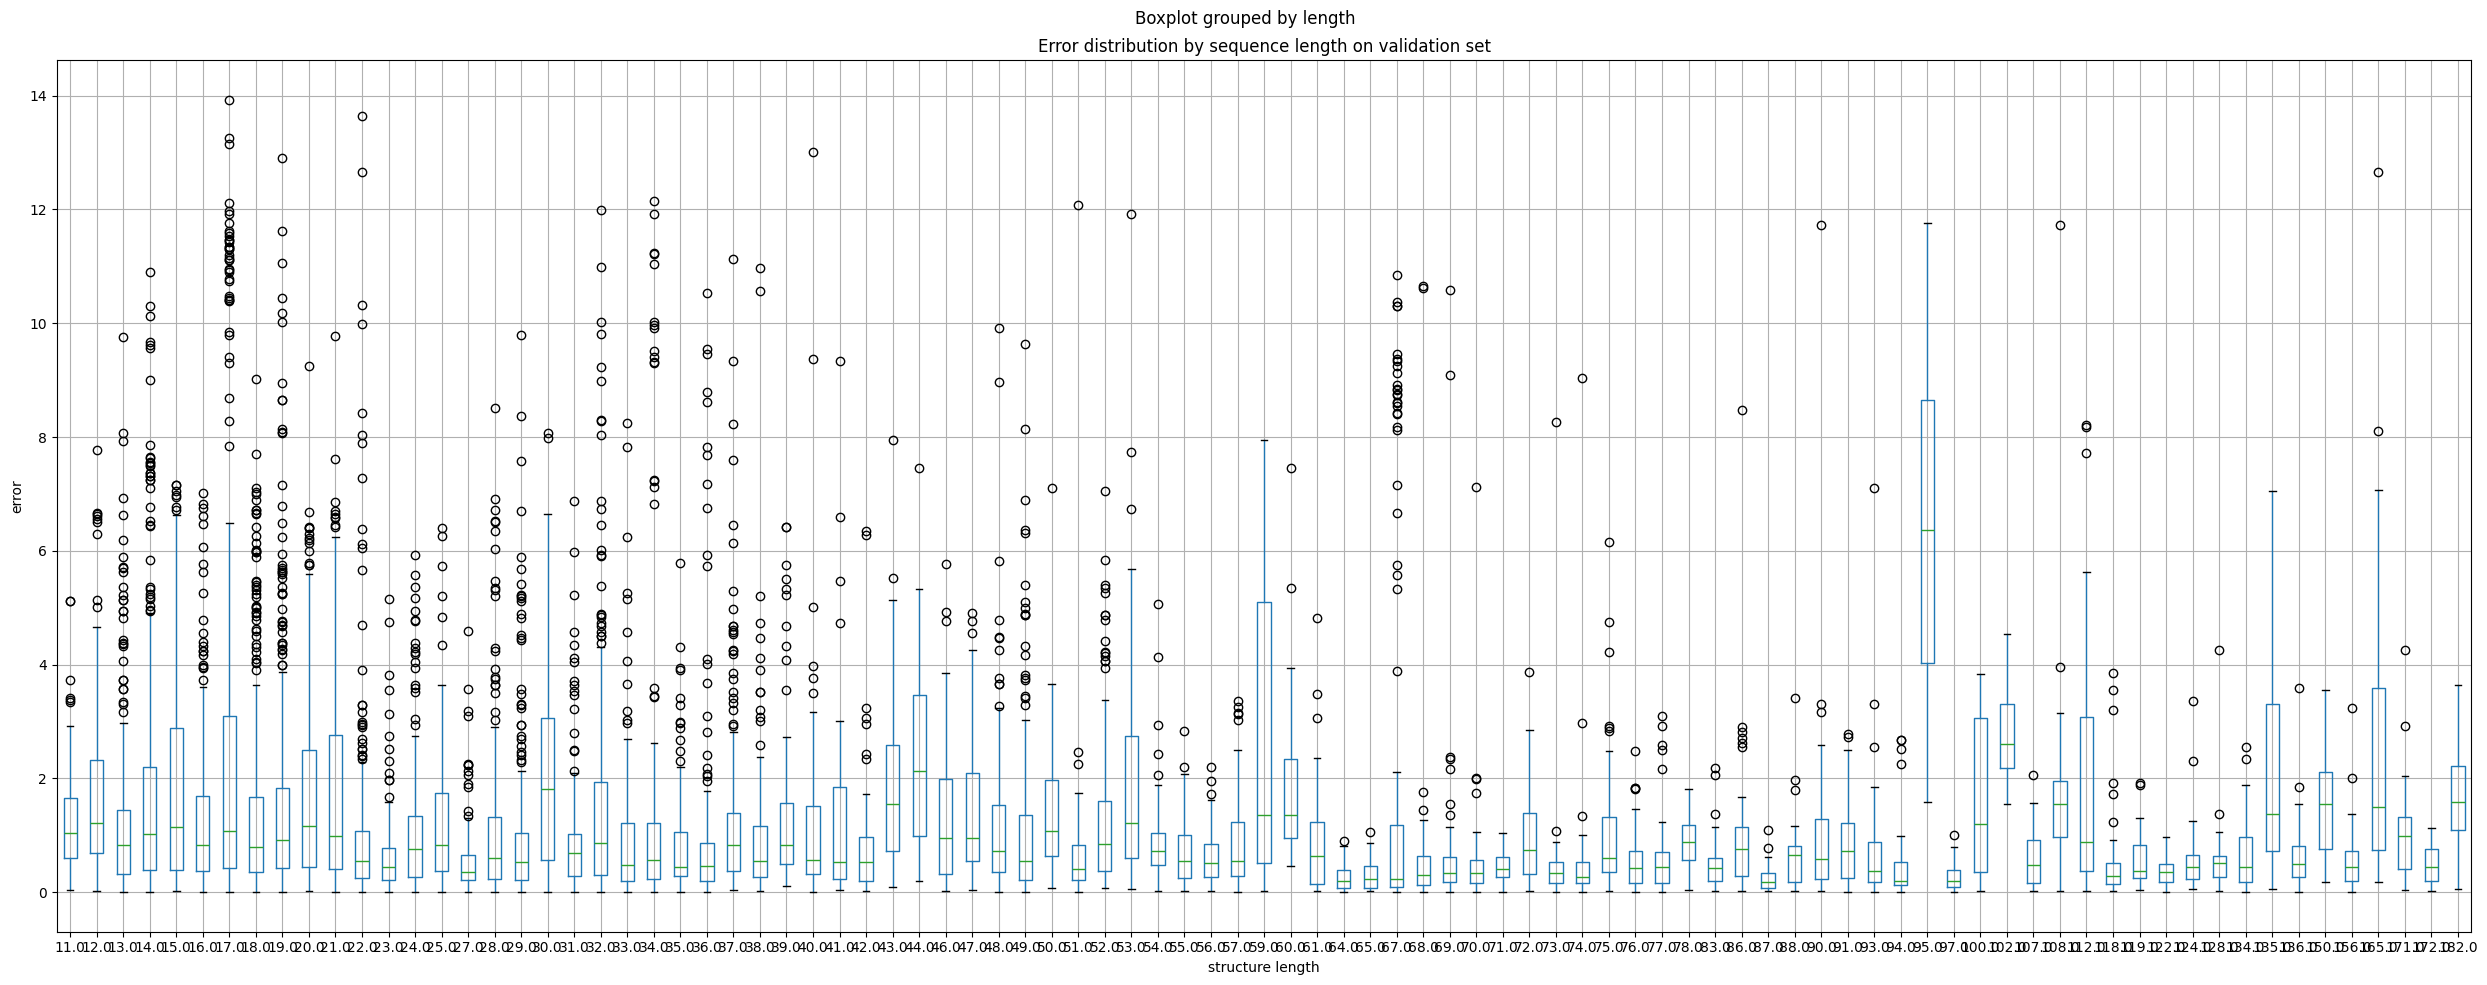

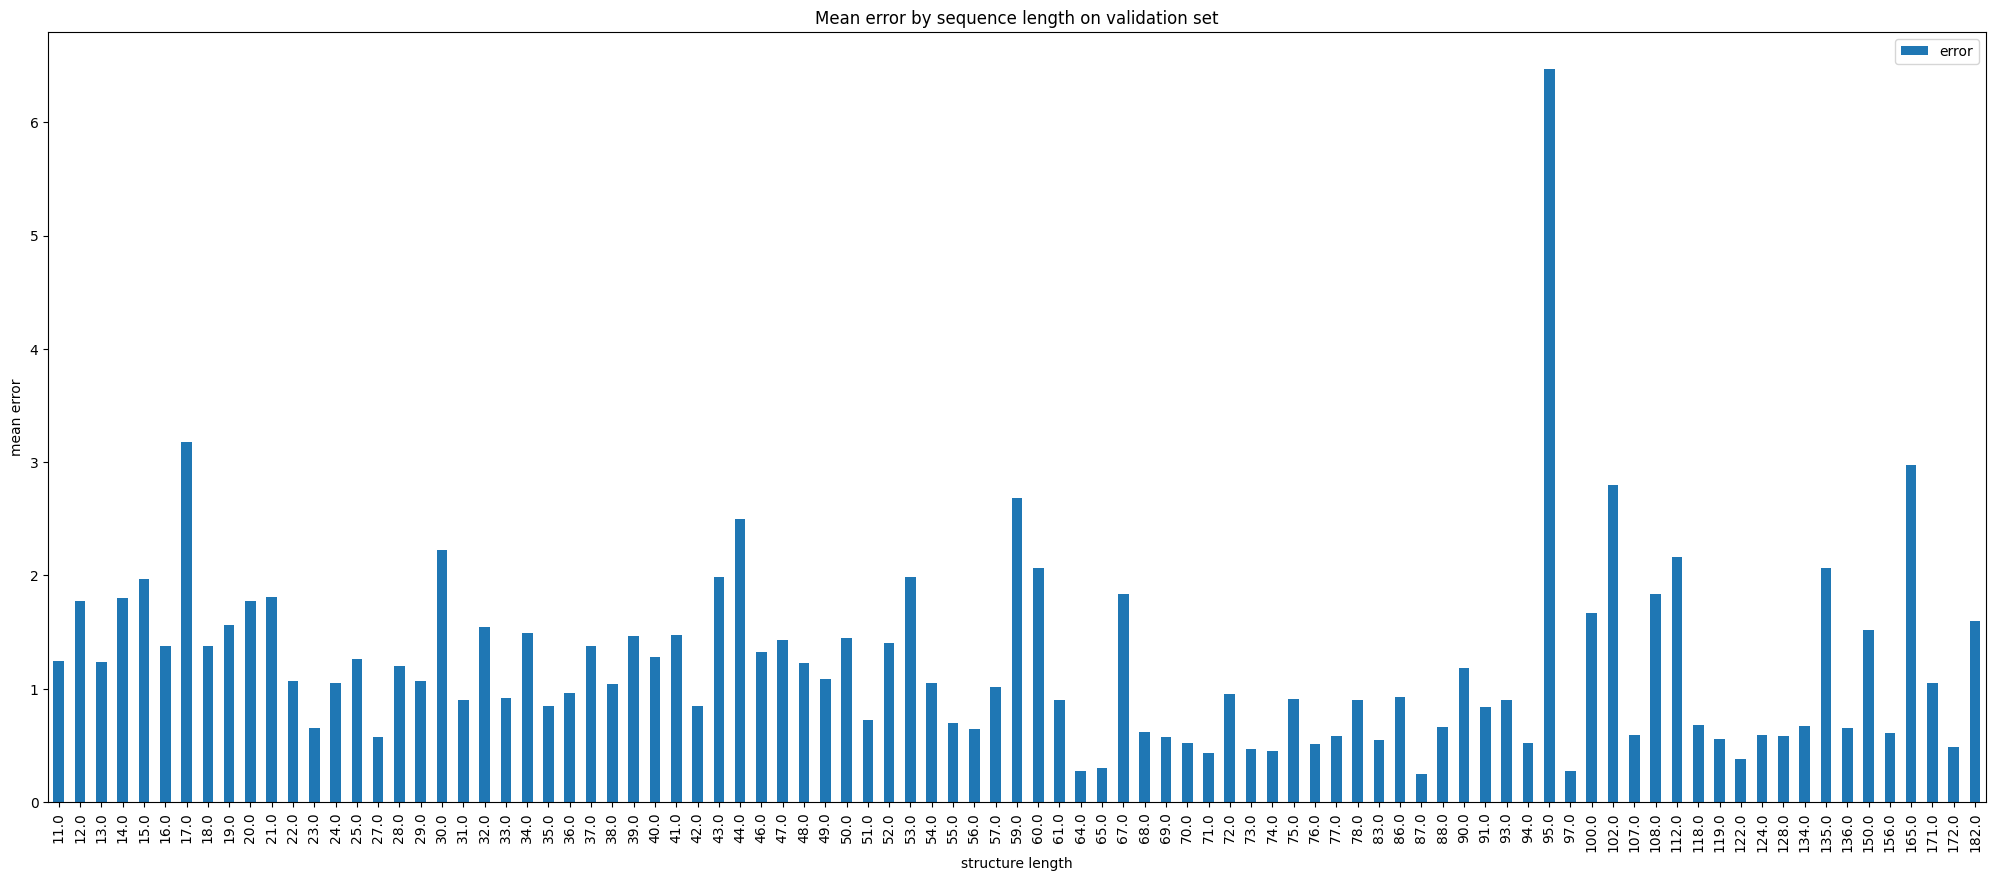

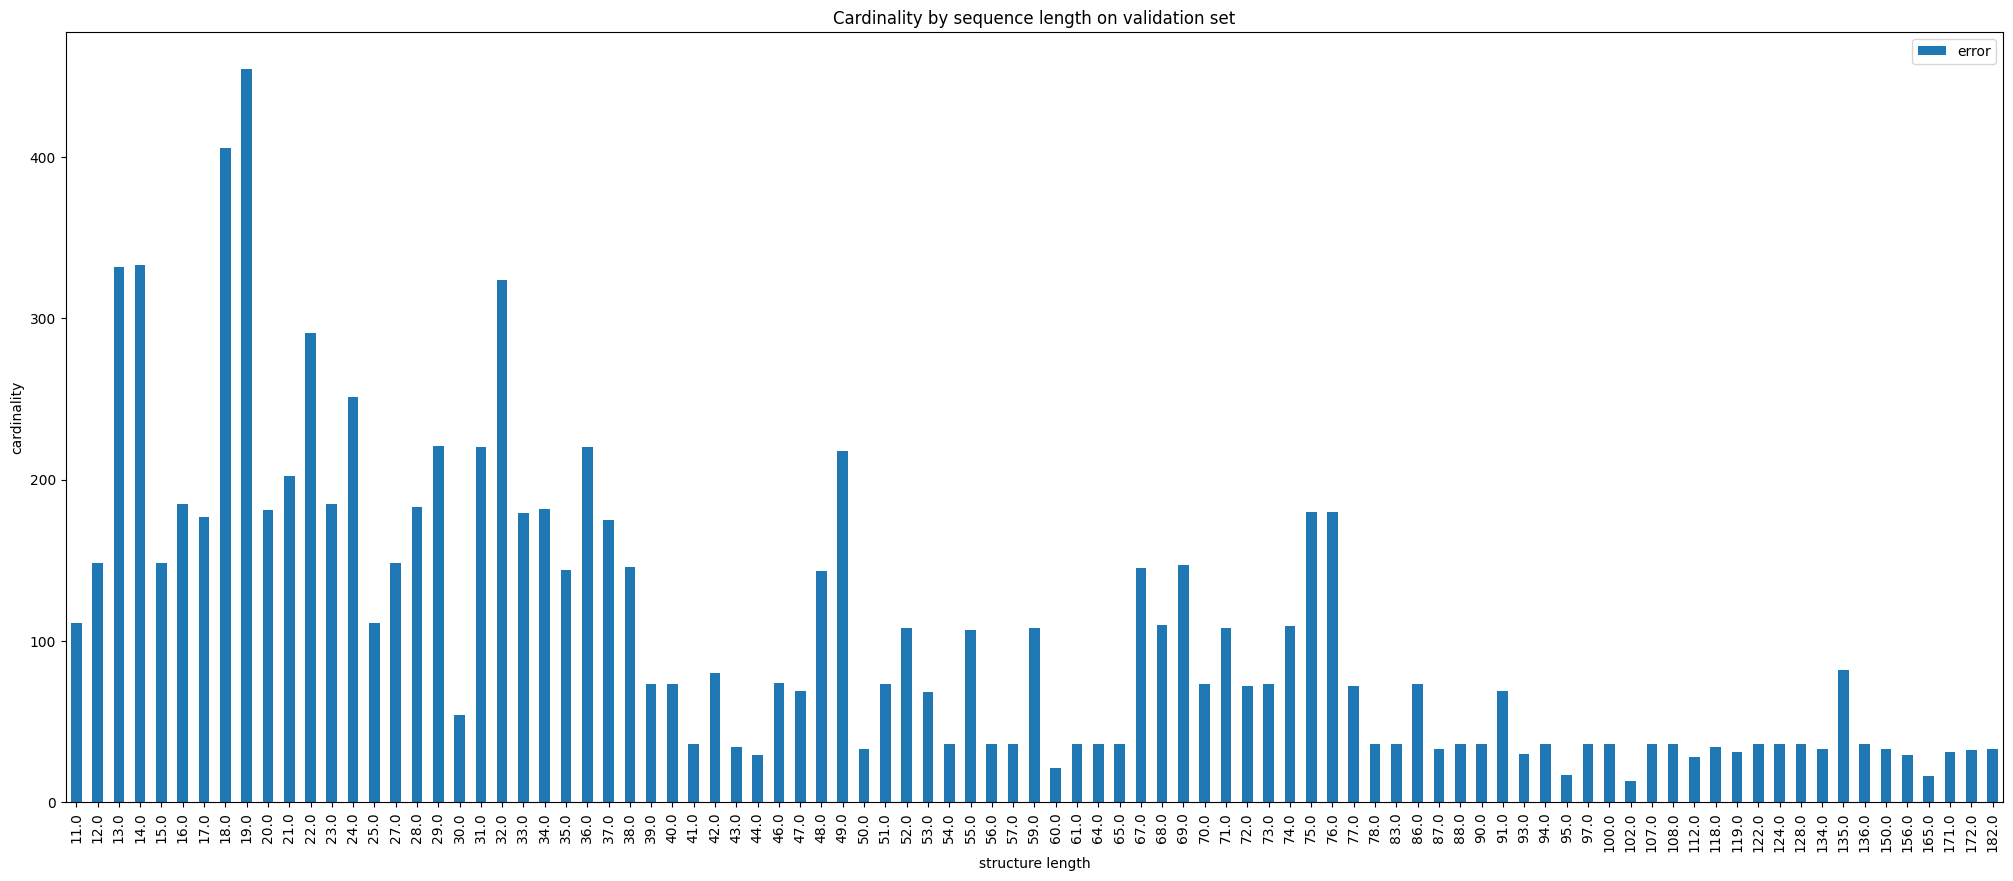

In [16]:
import datetime
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import MLFlowLogger

seed_everything(42)


class MetricTracker(L.Callback):
    def __init__(self):
        self.collection = []

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        vacc = outputs["val_loss_mae"]  # you can access them here
        self.collection.append(vacc)  # track them

    def on_validation_epoch_end(self, trainer, module):
        elogs = trainer.logged_metrics["val_loss_mae"]  # access it here
        self.collection.append(elogs)
        # do whatever is needed


model = RNAQuANet(dataset_train[0].x.shape[1], dataset_train[0].edge_attr.shape[1])

model_name = f"RNAQuANet-{dataset_dec_train.value['name']}_dataset__{'_'.join([s.value for s in SUBSETS])}"

mlf_logger = MLFlowLogger(
    experiment_name=f"{model_name}",
    # tracking_uri="/home/adamczykb/mlflow",
    # tracking_uri="192.168.88.253:5000",
    tracking_uri="https://www.bartekadamczyk.eu/mlflow/",
    log_model="all",
)
mlf_logger.log_hyperparams(
    {
        "model_name": model_name,
        "dataset_cutoff": CUTOFF,
        "subset": {"_".join([s.value for s in SUBSETS])},
        "dataset_size_train": len(dataset_train),
        "dataset_size_val": len(dataset_val),
        "dataset_train_summary": dataset_train.get_summary(),
        "dataset_val_summary": dataset_val.get_summary(),
    }
)
torch.set_float32_matmul_precision("high")
metr = MetricTracker()

# create your own theme!
progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)


model_checkpoint = ModelCheckpoint(monitor="val_loss_mae", save_top_k=1, mode="min")
trainer = L.Trainer(
    max_epochs=400,
    enable_progress_bar=True,  # callbacks=progress_bar,
    default_root_dir=f"/home/adamczykb/rnaquanet/checkpoints/{model_name}",
    # log_every_n_steps=25,
    callbacks=[
        EarlyStopping(monitor="val_loss_mae", mode="min", patience=15),
        model_checkpoint,
    ],
    logger=mlf_logger,
)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    model_checkpoint.best_model_path,
    number_of_node_features=dataset_train[0].x.shape[1],
    strict=False,
)
val_model = val_model.eval()
res = []
for i in dataset_val:
    res.append(
        [
            i.x.shape[0],
            float(
                abs(
                    i.y.cpu()
                    - val_model(
                        i.x.cuda(),
                        i.edge_index.cuda(),
                        i.edge_attr.cuda(),
                        torch.zeros(i.x.shape[0], dtype=torch.int64).cuda(),
                    )
                    .detach()
                    .cpu()
                    .numpy()
                )
            ),
        ]
    )
df = pd.DataFrame(np.array(res), columns=["length", "error"])
fig, ax = plt.subplots(figsize=(25, 10))

df.boxplot(column="error", by="length", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("error")
ax.set_title("Error distribution by sequence length on validation set")
plt.tight_layout()
mlf_logger.experiment.log_figure(
    mlf_logger.run_id, fig, "error_distribution_by_length.svg"
)
mlf_logger.experiment.log_text(
    mlf_logger.run_id, str(val_model.eval()), "architecture.txt"
)
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").mean().plot(kind="bar", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("mean error")
ax.set_title("Mean error by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id, fig, "error_mean_by_length.svg")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").count().plot(kind="bar", ax=ax)

ax.set_xlabel("structure length")
ax.set_ylabel("cardinality")
ax.set_title("Cardinality by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id, fig, "cardinality_by_length.svg")
plt.show()

mlf_logger.experiment.log_metric(
    mlf_logger.run_id,
    "best_val_loss_mae",
    model_checkpoint.best_model_score.cpu().tolist(),
)
mlf_logger.experiment.log_metric(
    mlf_logger.run_id, "best_val_loss_mse", (df["error"] ** 2.0).mean()
)

tensor(1.)

In [19]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/117a12e5f3ad4fff9c0bc76972c07242/checkpoints/epoch=102-step=34093.ckpt'

In [6]:
best_model_path='/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-combined_dataset__all/493488456530092571/f8c289b7024c4143ad4856b0ff10284e/checkpoints/epoch=28-step=14355.ckpt'

In [22]:
model_checkpoint.best_model_path

'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/d27427a3cab649fb836d3ca9620b46d0/checkpoints/epoch=27-step=8596.ckpt'

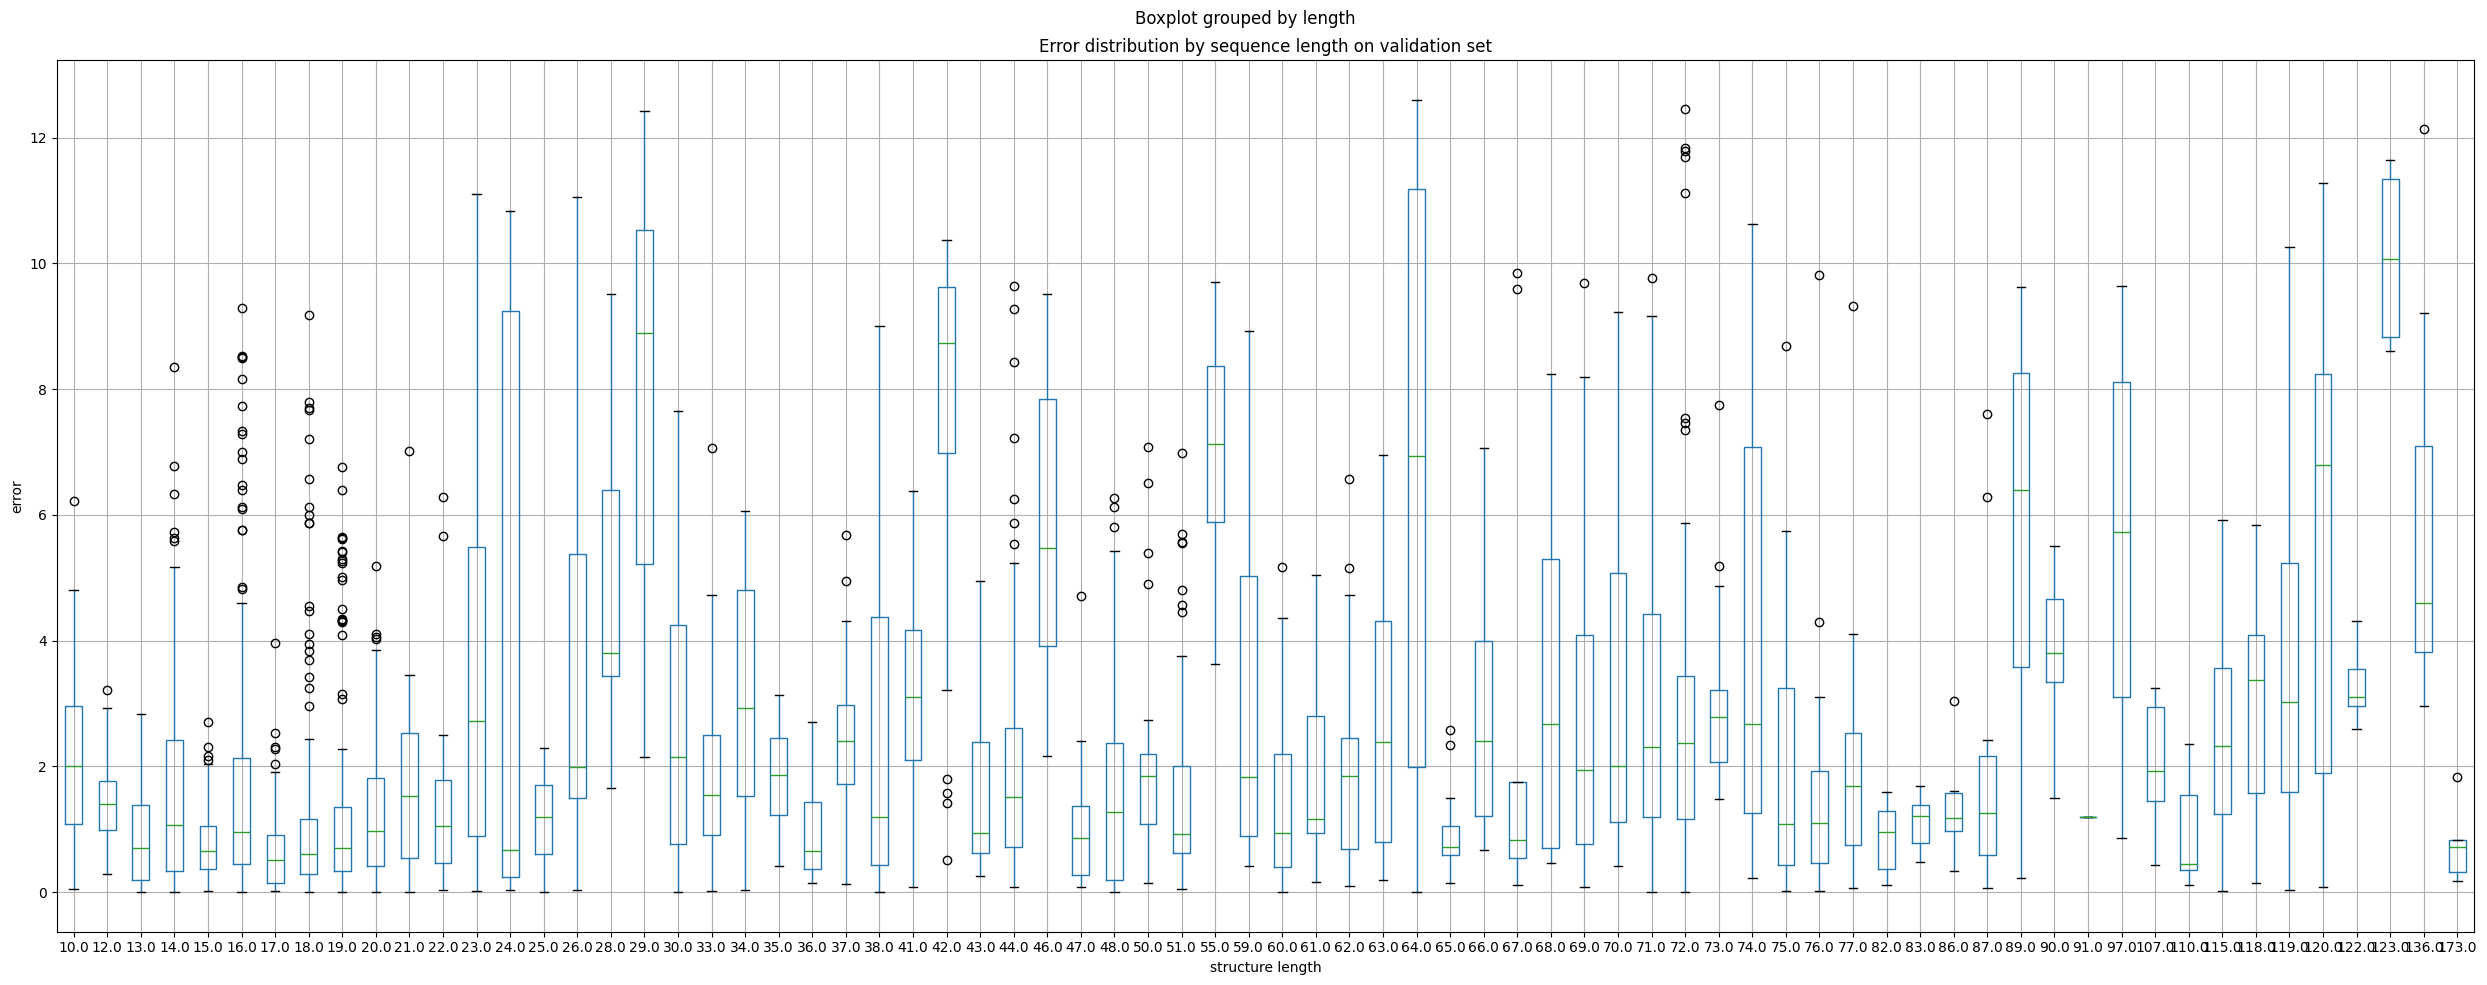

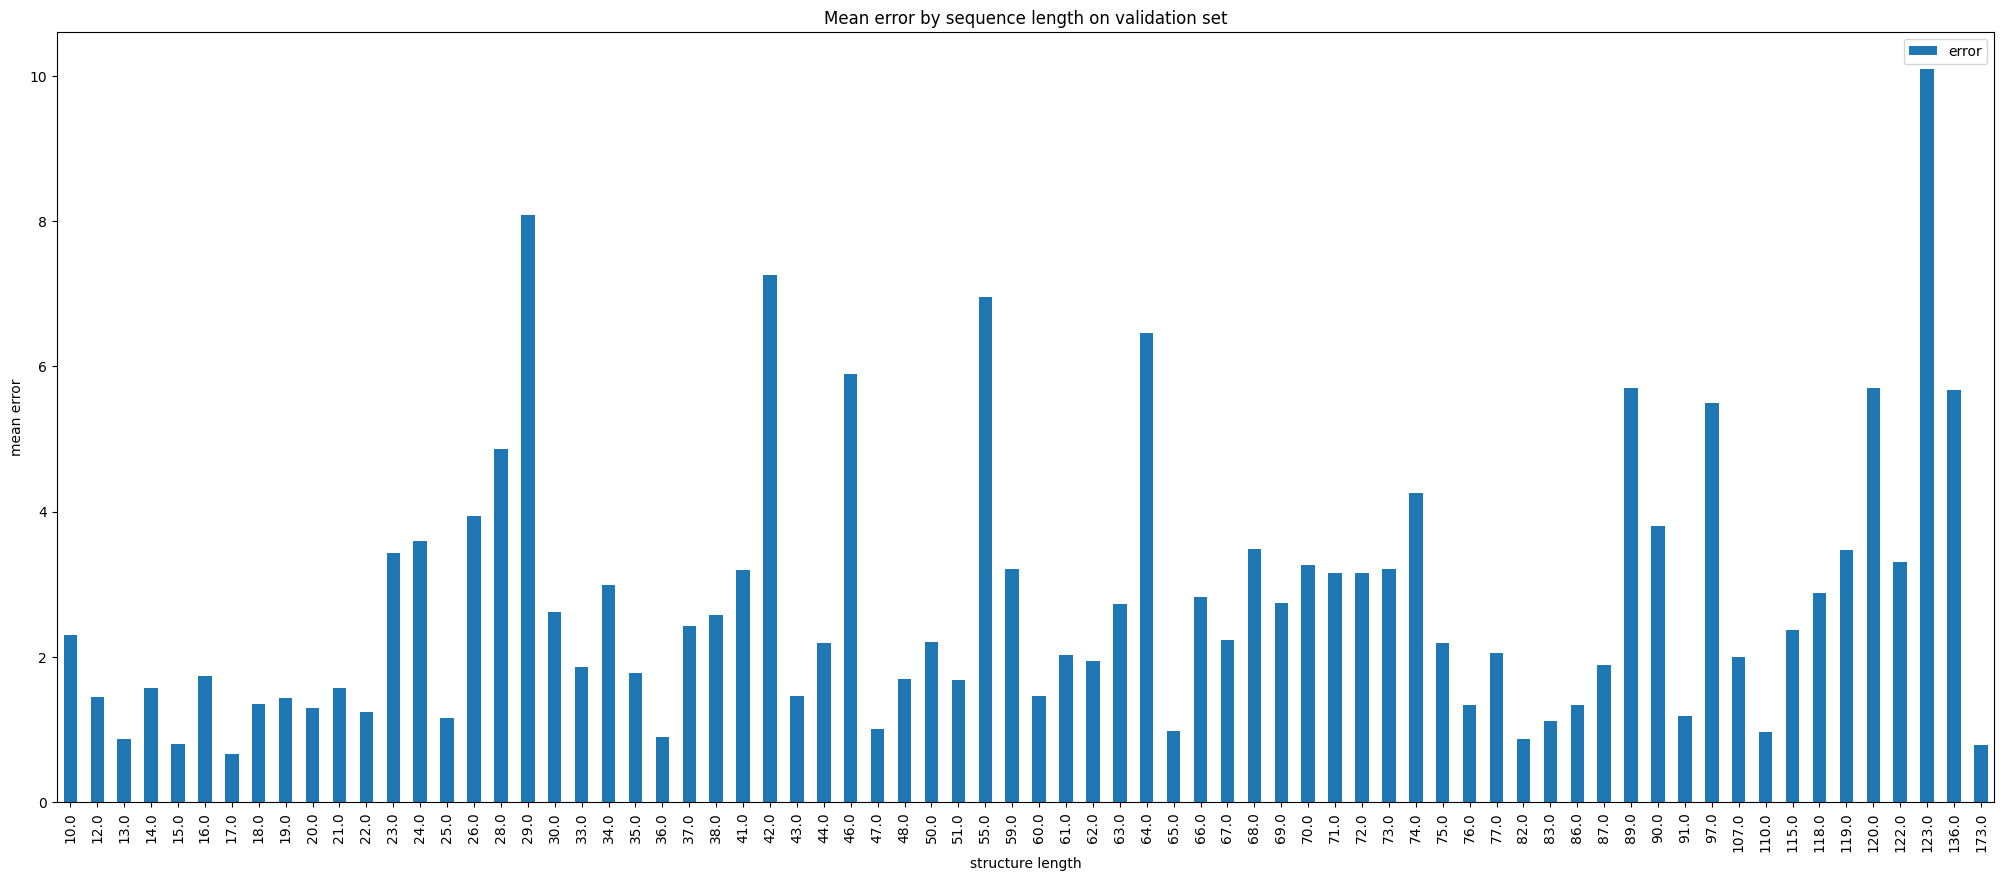

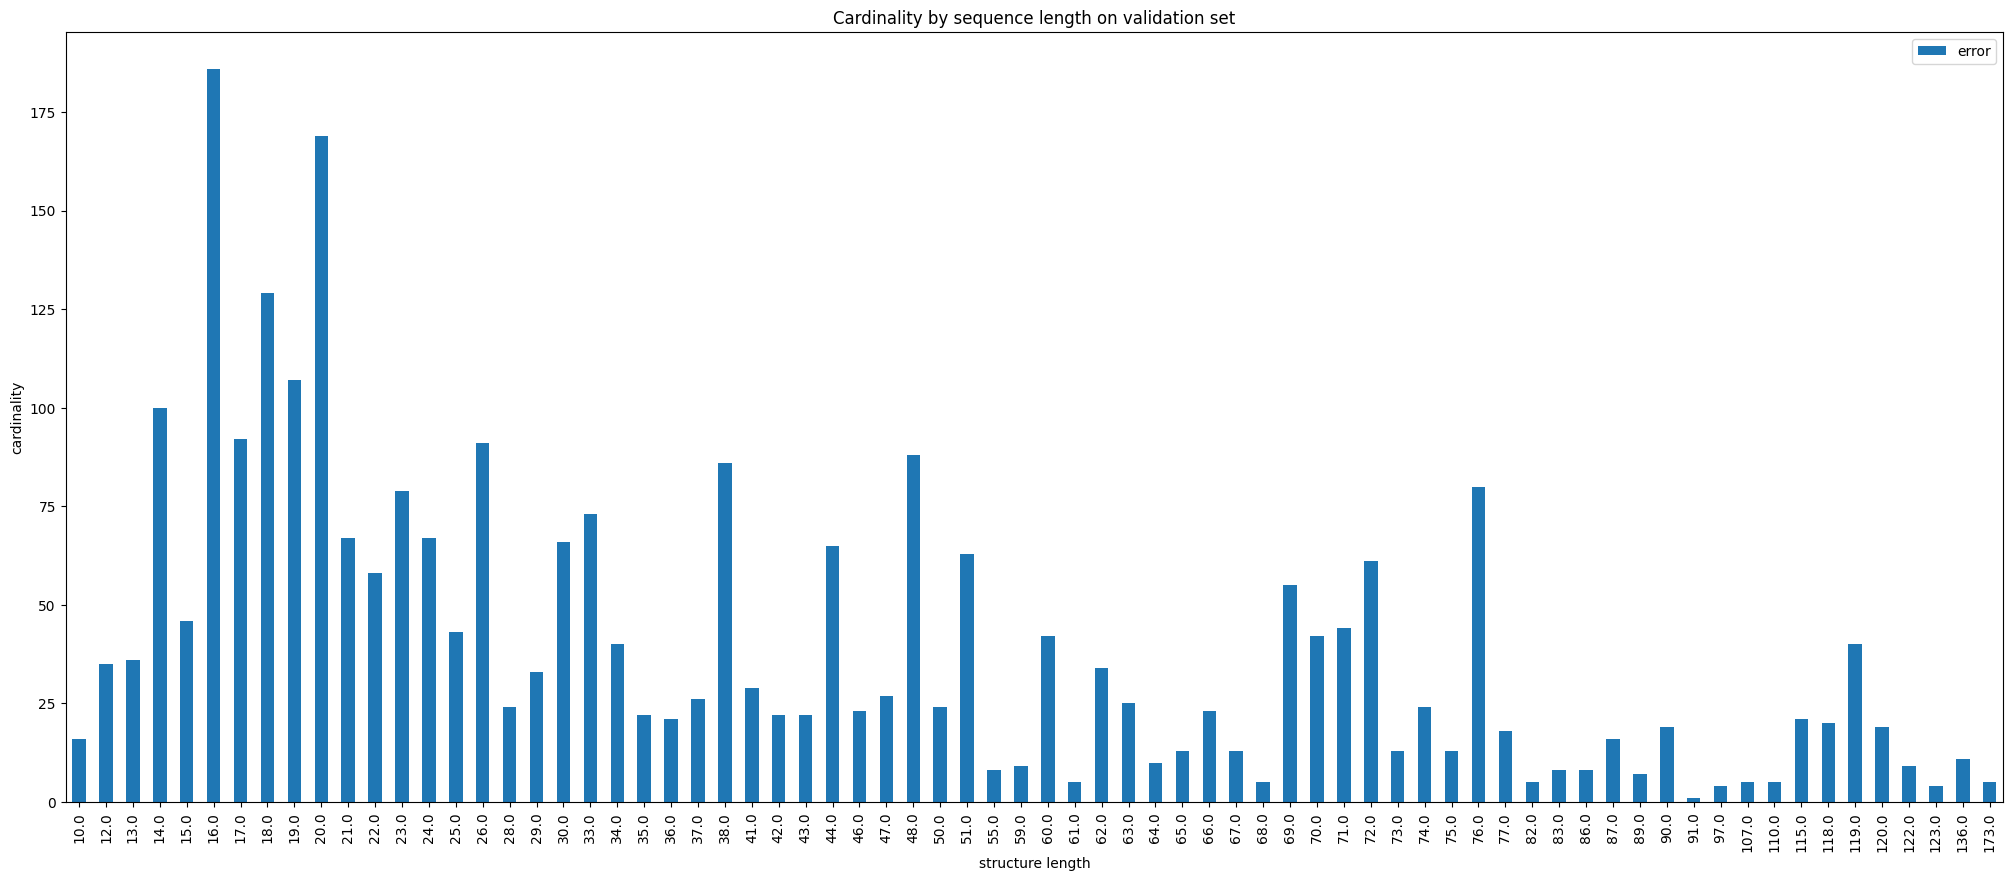

In [15]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

val_model = RNAQuANet.load_from_checkpoint(
    model_checkpoint.best_model_path,
    number_of_node_features=dataset_train[0].x.shape[1],strict=False
)
val_model=val_model.eval()
res = []
for i in dataset_val:
    res.append(
        [
            i.x.shape[0],
            float(
                abs(
                    i.y.cpu()
                    - val_model(i.x.cuda(), i.edge_index.cuda(), i.edge_attr.cuda(), torch.zeros(i.x.shape[0],dtype=torch.int64).cuda()).detach().cpu().numpy()
                )
            ),
        ]
    )
df = pd.DataFrame(np.array(res), columns=["length", "error"])
fig, ax = plt.subplots(figsize=(25, 10))

df.boxplot(column="error", by="length", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("error")
ax.set_title("Error distribution by sequence length on validation set")
plt.tight_layout()
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_distribution_by_length.svg")
mlf_logger.experiment.log_text(mlf_logger.run_id,str(val_model.eval()), "architecture.txt")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").mean().plot(kind="bar", ax=ax)
ax.set_xlabel("structure length")
ax.set_ylabel("mean error")
ax.set_title("Mean error by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id,fig, "error_mean_by_length.svg")
plt.show()

fig, ax = plt.subplots(figsize=(25, 10))
df.groupby("length").count().plot(kind="bar", ax=ax)

ax.set_xlabel("structure length")
ax.set_ylabel("cardinality")
ax.set_title("Cardinality by sequence length on validation set")
mlf_logger.experiment.log_figure(mlf_logger.run_id, fig, "cardinality_by_length.svg")
plt.show()

mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mae", model_checkpoint.best_model_score.cpu().tolist())
mlf_logger.experiment.log_metric(mlf_logger.run_id,"best_val_loss_mse", (df["error"]**2.0).mean())


In [10]:
model_checkpoint.best_model_path

'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-lociparse_dataset__all/920236849910850327/333226a0193146909c189016a26e4127/checkpoints/epoch=45-step=15226.ckpt'

In [50]:
val_model = RNAQuANet.load_from_checkpoint(
'/home/adamczykb/rnaquanet/checkpoints/RNAQuANet-ares_dataset__all/306037256498709437/907d0b5d821048268dfe231227affa42/checkpoints/epoch=11-step=672.ckpt',
    number_of_node_features=dataset_train[0].x.shape[1],strict=False
)
val_model.eval()
val_model._trainer = L.Trainer()
m=torch.jit.script(val_model).cuda()
torch.jit.save(m,f"/tmp/{mlf_logger.run_id}.pt")
mlf_logger.experiment.log_artifact(mlf_logger.run_id,
    f"/tmp/{mlf_logger.run_id}.pt",
    artifact_path="model"
)

mlflow.pytorch.log_model(mlf_logger.run_id, val_model, "models")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NotSupportedError: Compiled functions can't take variable number of arguments or use keyword-only arguments with defaults:
  File "/home/adamczykb/rnaquanet/.venv/lib/python3.13/site-packages/torch_geometric/nn/conv/message_passing.py", line 425
        edge_index: Adj,
        size: Size = None,
        **kwargs: Any,
         ~~~~~~~ <--- HERE
    ) -> Tensor:
        r"""The initial call to start propagating messages.


In [33]:
train_loader = DataLoader(dataset_train, num_workers=24, batch_size=125, shuffle=True)

